<a href="https://colab.research.google.com/github/sayandas96476/gemstone-identification-using-deep-learning-approach/blob/main/Custom%20ResNet(with%20test%20accuracy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow
tensorflow.__version__

'2.8.2'

In [ ]:
!unzip -u /content/drive/MyDrive/test.zip -d /content
!unzip -u /content/drive/MyDrive/train.zip -d /content

Archive:  /content/drive/MyDrive/test.zip
Archive:  /content/drive/MyDrive/train.zip


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
train_path = '/content/train'
test_path = '/content/test'
BATCH_SIZE = 64
IMG_SIZE = 224 #for vgg-16/19
seed=123
input_shape = (IMG_SIZE,IMG_SIZE)
# Validation ImageDataGenerator with rescaling.
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# Training ImagaDataGenerator with Augmentation transf.  
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,\
                                   rotation_range=15, shear_range=10,\
                                   zoom_range=0.1, fill_mode='nearest', \
                                   height_shift_range=0.05, width_shift_range=0.1)

# Create a flow from the directory for validation data - seed=42
# Choose subset = 'validation'
valid_gen = valid_datagen.flow_from_directory(directory=train_path,subset='validation',
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    interpolation='nearest'
)
# Create a flow from the directory using same seed and 'training' subset.
train_gen = train_datagen.flow_from_directory(subset='training',
    directory=train_path,
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    interpolation='nearest'
)

Found 543 images belonging to 87 classes.
Found 2313 images belonging to 87 classes.


In [ ]:
n_classes=87

In [ ]:
class_indices = train_gen.class_indices

In [ ]:
temp_df = pd.DataFrame({'class': train_gen.classes}).value_counts().reset_index().sort_values(by='class')
#temp_df['class_name'] = 
temp_df.columns = ['class', 'counts']

Number of images:  2313


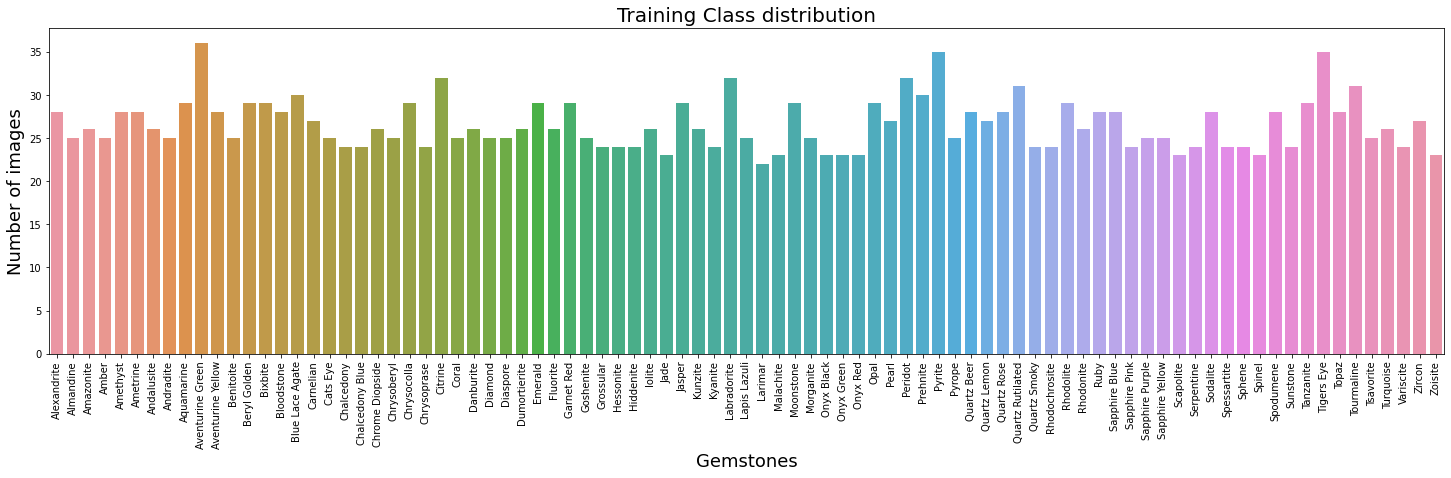

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(data=temp_df,
            x='class',
            y='counts')
plt.ylabel('Number of images', fontsize=18)
plt.xlabel('Gemstones', fontsize=18)
plt.title('Training Class distribution', fontsize=20)
plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

print('Number of images: ', np.sum(temp_df['counts'].values))

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
def Resblock2D_v2(x, kernel_size, out_filters, strides, dilation_rate, elu_alpha, name):
    fx = tf.keras.layers.BatchNormalization(name=name+'bn1')(x)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act1')(fx)
    fx = tf.keras.layers.Conv2D(out_filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate, name=name+'conv2')(fx)
    fx = tf.keras.layers.BatchNormalization(name=name+'bn2')(fx)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act2')(fx)
    fx = tf.keras.layers.Conv2D(out_filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate, name=name+'conv3')(fx)
    out = tf.keras.layers.Add(name=name+'add')([x,fx])
    return out

def Resblock1D_v2(x, n_units, elu_alpha, name):
    fx = tf.keras.layers.BatchNormalization(name=name+'bn1')(x)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act1')(fx)
    fx = tf.keras.layers.Dense(n_units, name=name+'dense2')(fx)
    fx = tf.keras.layers.BatchNormalization(name=name+'bn2')(fx)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act2')(fx)
    fx = tf.keras.layers.Dense(n_units, name=name+'dense3')(fx)
    out = tf.keras.layers.Add(name=name+'add')([x,fx])
    return out

def Custom_model(input_shape, n_classes, elu_alpha):
    
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    
    # increase dim
    x = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='valid', input_shape=input_shape, name='block1_conv1')(input_layer)
    # resblock
    x = Resblock2D_v2(x, kernel_size=(3,3), out_filters=32, strides=(1,1), dilation_rate=(1,1), elu_alpha=elu_alpha, name='block1_')
    
    filters = [64, 128, 256]
    for block_num, n_filters in enumerate(filters, 2):
        # pre bn and act
        block_name = 'block'+str(block_num)+'_'
        x = tf.keras.layers.BatchNormalization(name=block_name+'pre_bn')(x)
        x = tf.keras.layers.ELU(alpha=elu_alpha, name=block_name+'pre_act')(x)
        # decrease img size
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name=block_name+'maxpool')(x)
        # increase dim
        x = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', input_shape=input_shape, name=block_name+'conv1')(x)
        # resblock
        x = Resblock2D_v2(x, kernel_size=(3,3), out_filters=n_filters, strides=(1,1), dilation_rate=(1,1), elu_alpha=elu_alpha, name=block_name)

    # Prediction layers
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization(name='pre_global_avg_pool_bn')(x)
    x = tf.keras.layers.ELU(alpha=elu_alpha, name='pre_global_avg_pool_act')(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    #x = tf.keras.layers.Flatten()(x)
    
    # Dense layer
    block_num += 1
    block_name = 'block'+str(block_num)+'_'
    x = tf.keras.layers.Dense(256, name=block_name+'dense1')(x)
    # Residual block
    x = Resblock1D_v2(x, n_units=256, elu_alpha=elu_alpha, name=block_name)
    
    # Output layer
    x = tf.keras.layers.BatchNormalization(name='pre_output_bn')(x)
    x = tf.keras.layers.ELU(alpha=elu_alpha, name='pre_output_act')(x)
    x = tf.keras.layers.Dense(n_classes)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name='Custom_model')

In [ ]:
model = Custom_model(list(input_shape)+[3],87,1.0)

In [ ]:
model.summary()

Model: "Custom_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 block1_bn1 (BatchNormalization  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 )                              )                                                      

In [ ]:
from keras.metrics import TopKCategoricalAccuracy
model.compile(
     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
     optimizer='adam',
    metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping

In [ ]:
checkpoint_path = "/content/drive/MyDrive/custom_resnet_holdout/weights.ckpt"

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
#Early Stopping
earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=30, 
    verbose=0,
    mode='max')

history_cb = CSVLogger('/content/drive/MyDrive/custom_resnet_holdout/log.csv', separator=",", append=False)

In [ ]:
r = model.fit(
  train_gen,
  validation_data=valid_gen,
  epochs=125,
  callbacks=[history_cb,earlystopping_cb,cp_callback]
)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 363 images belonging to 87 classes.


In [ ]:
model.load_weights(checkpoint_path)
model.compile(
     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
     optimizer='adam',
    metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")])
# Re-evaluate the model
loss, acc , top_3_acc, top_5_acc = model.evaluate(test_set)
print("Restored model from checkpoint;\ntop-1 accuracy: {:5.2f}%,top-3 accuracy: {:5.2f}%\ntop-5 accuracy: {:5.2f}%".format(100 * acc,100*top_3_acc,100*top_5_acc))

6/6 [==============================] - 11s 2s/step - loss: 0.9681 - accuracy: 0.7245 - top-3 accuracy: 0.9118 - top-5 accuracy: 0.9559
Restored model from checkpoint;
top-1 accuracy: 72.45%,top-3 accuracy: 91.18%
top-5 accuracy: 95.59%


In [ ]:
print("Restored model from checkpoint;\ntop-1 accuracy: {:5.2f}%\ntop-3 accuracy: {:5.2f}%\ntop-5 accuracy: {:5.2f}%".format(100 * acc,100*top_3_acc,100*top_5_acc))

Restored model from checkpoint;
top-1 accuracy: 72.45%
top-3 accuracy: 91.18%
top-5 accuracy: 95.59%


In [ ]:
def plot_confusion_matrix(data_gen, title=''):
    n_batches = int(np.ceil(data_gen.n/BATCH_SIZE))
    classes_df = pd.DataFrame()

    for batch in np.arange(n_batches):
        classes = np.argmax(data_gen[batch][1], axis=1)
        temp_df = pd.DataFrame(classes)
        classes_df = classes_df.append(temp_df, ignore_index=True)
    classes_df.columns = ['true_class']

    #logits and probs
    logits = model.predict(data_gen)
    probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

    classes_df['predicted_class'] = np.argmax(probs, axis=1)
    
    conf_matrix = confusion_matrix(classes_df.true_class.values, 
                                    classes_df.predicted_class.values, 
                                    labels=np.arange(n_classes))
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
    
    plt.figure(figsize=(40,30))
    sns.heatmap(conf_matrix_norm, 
                cmap='viridis',
                annot=conf_matrix_norm,
                vmin=0, vmax=1,)
    _ = plt.title(title, fontsize=25)
    _ = plt.yticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=0)
    _ = plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

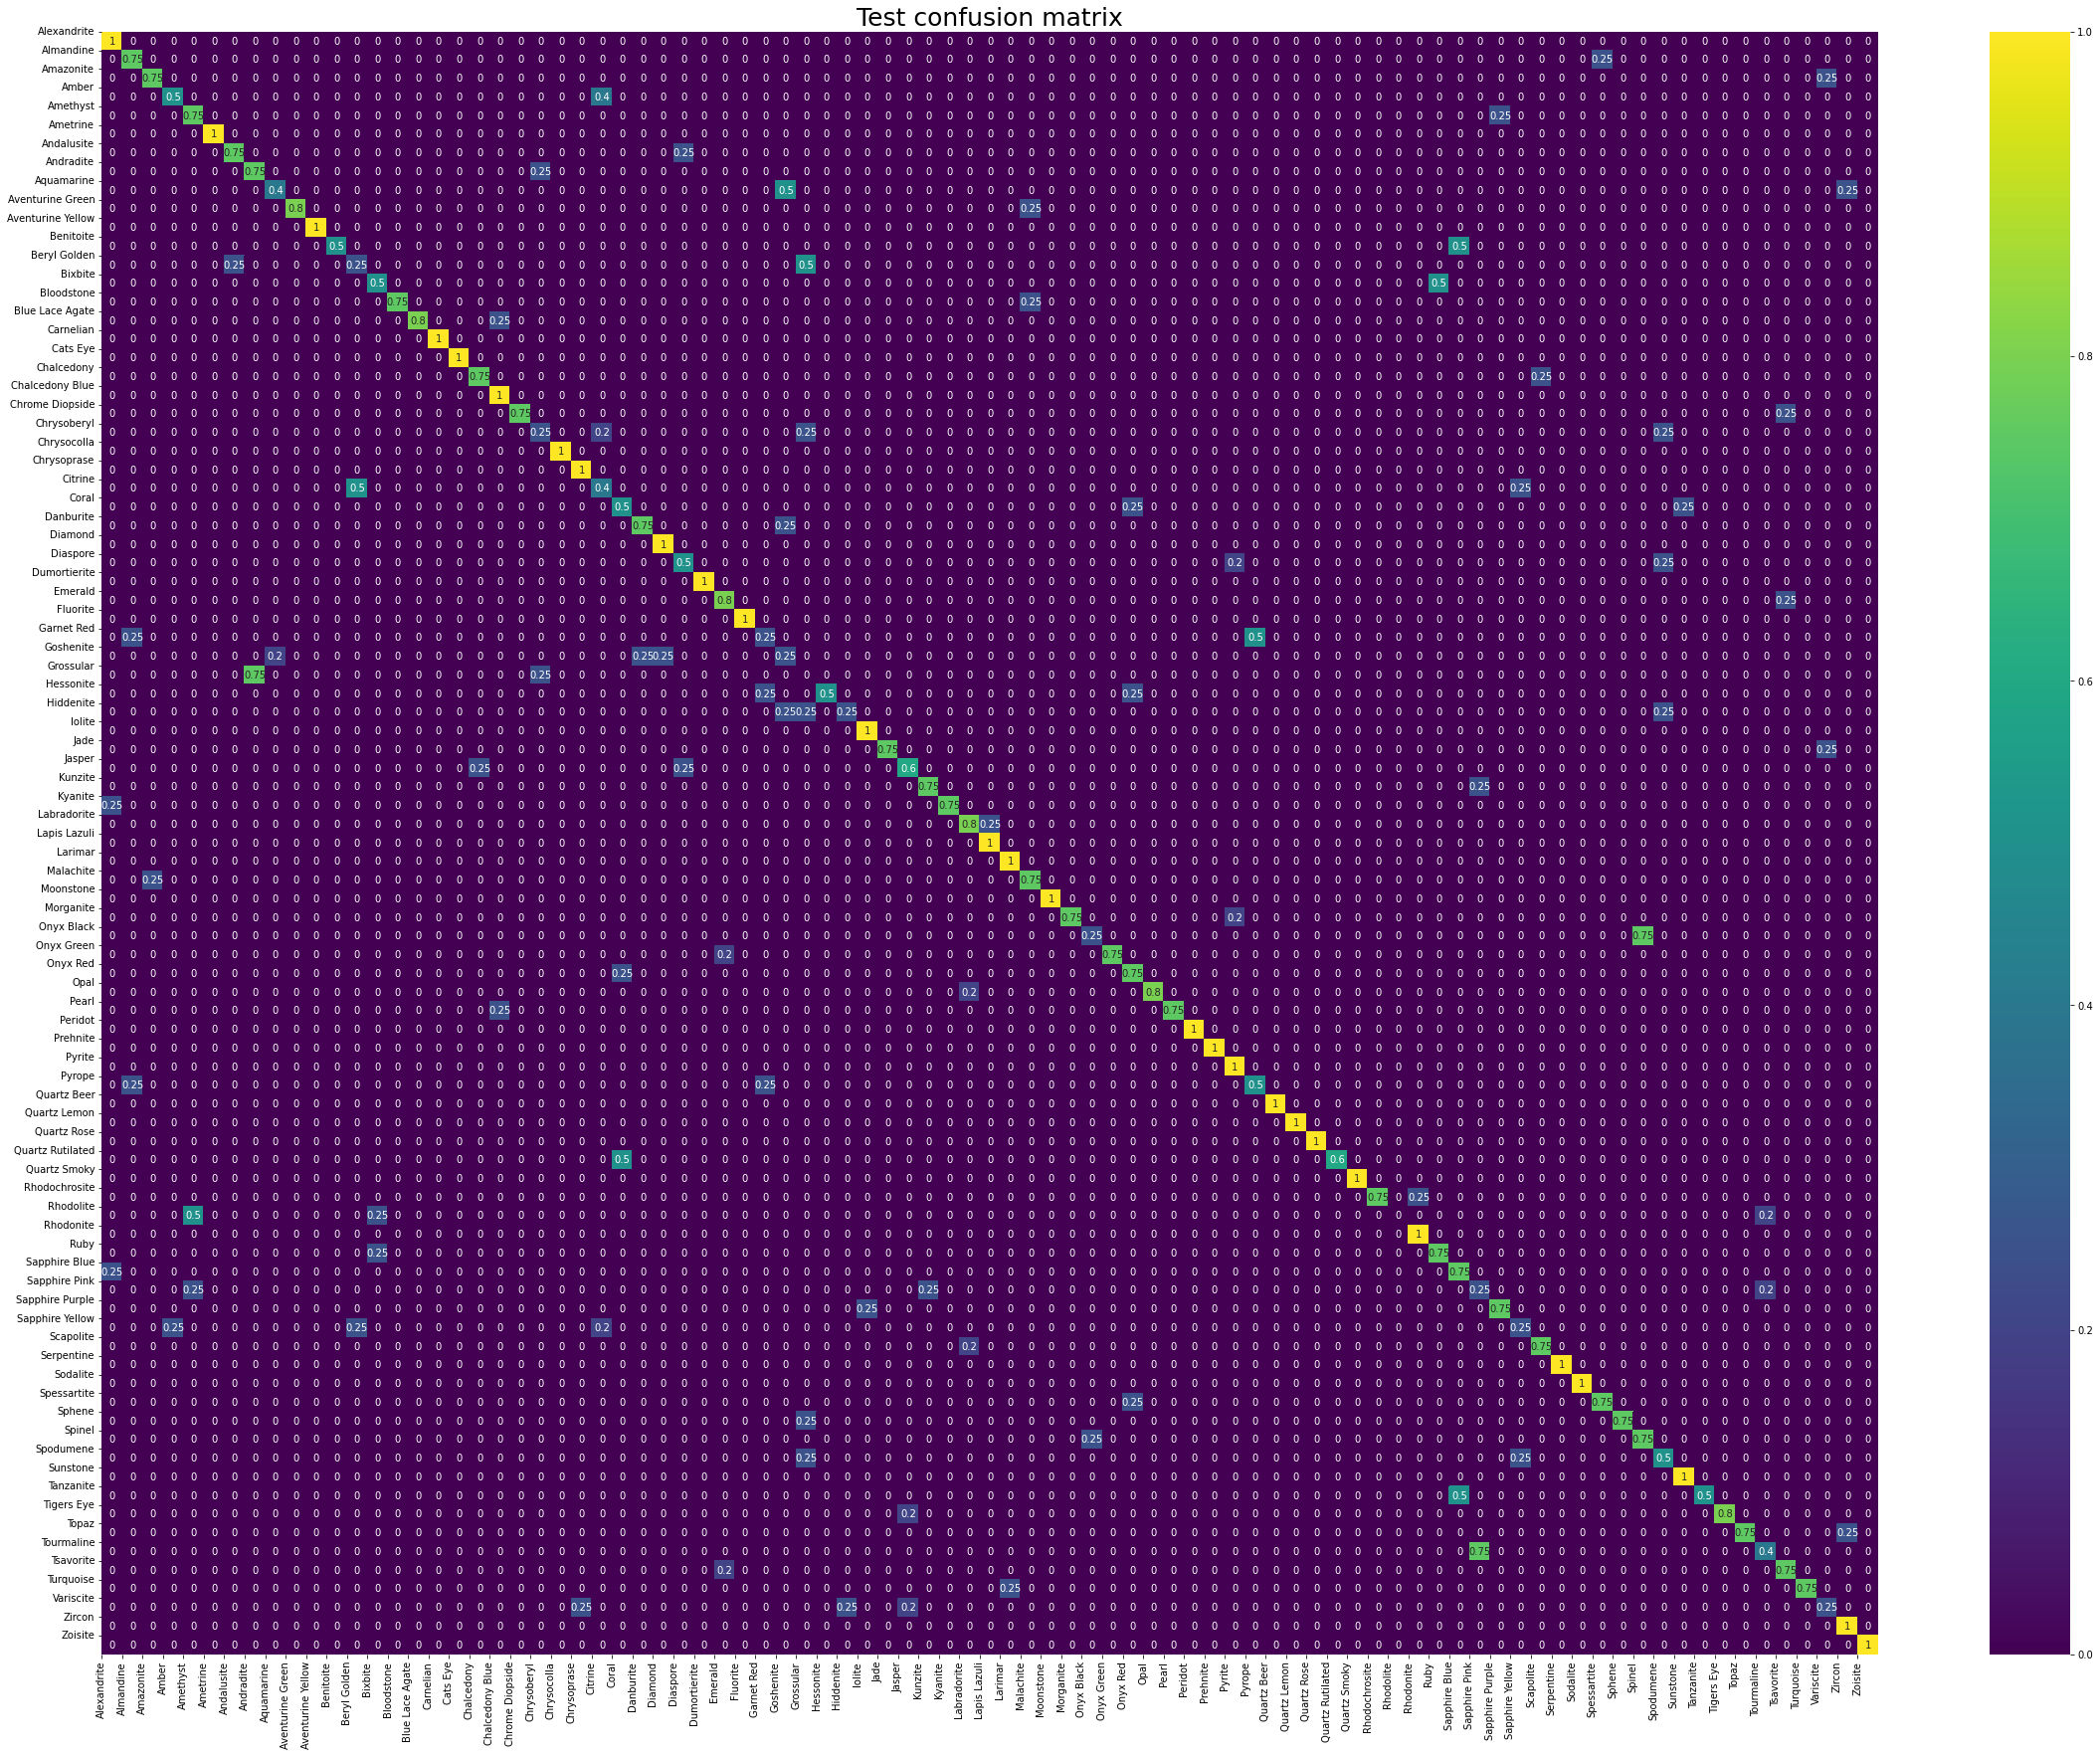

In [ ]:
plot_confusion_matrix(test_set, 'Test confusion matrix')

In [ ]:
n_batches = int(np.ceil(test_set.n/BATCH_SIZE))
classes_df = pd.DataFrame()

for batch in np.arange(n_batches):
    classes = np.argmax(test_set[batch][1], axis=1)
    temp_df = pd.DataFrame(classes)
    classes_df = classes_df.append(temp_df, ignore_index=True)
classes_df.columns = ['true_class']

In [ ]:
#logits and probs
logits = model.predict(test_set)
probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

classes_df['predicted_class'] = np.argmax(probs, axis=1)

In [ ]:
Y_true = classes_df["true_class"]
Y_pred = classes_df["predicted_class"]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(Y_true,Y_pred,average='macro')
recall = recall_score(Y_true,Y_pred,average='macro')
f1 = f1_score(Y_true,Y_pred,average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("precision: ",precision,"\nrecall: ",recall,"\nf1_score: ",f1)

precision:  0.74168035030104 
recall:  0.7235632183908045 
f1_score:  0.7198702957323645
